In [17]:
!pip install pmdarima
!pip install holidays


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import datetime

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf  # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders


from statsmodels.tsa.stattools import adfuller

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Forecasting with a SARIMAX model

What is the difference between a SARIMA and SARIMAX, the latter incoporates an exongenous variable. The dependent variable lagged is not the only variable in the model.

Exogenous variables have a special attribute, the future value has to be known. A good example is to think of Holidays, we know what days will be a holiday in the future. Also promotions or discounts, if a company runs a weekly promtion on Friday this can affect sales for that day and possibly have an effect into the comming days. 

This notebook will go over an end-to-end example on employing a SARIMAX model on daily sales data

In [19]:
# Load data


df = pd.read_csv('/content/train.csv',index_col='date',parse_dates=True)


df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [20]:
# Resample the data so it is aggregated daily (i.e. total daily sales for all stores and items)

df=df.resample("d").sum()[['sales']]


df.head(30)

,sales
date,
2013-01-01,13696
2013-01-02,13678
2013-01-03,14488
2013-01-04,15677
2013-01-05,16237
2013-01-06,17291
2013-01-07,11769
2013-01-08,13560
2013-01-09,13878


#Holidays 

The next section will go through process of finding all of the holidays in the data frame

In [21]:
# Frist, we need to find the first and last years in the data frame

df.iloc[0],df.iloc[-1]

(sales    13696
 Name: 2013-01-01 00:00:00, dtype: int64, sales    26420
 Name: 2017-12-31 00:00:00, dtype: int64)

In [22]:
# Here is a nice function for adding holidays to a data set by creating a dummy variable 




def holiday_finder(df, years="a tuple of all years in the df", start_year = "first year in df", end_year = "last year in df"): 

  holiday_list = []

  for date in holidays.UnitedStates(years = years).items(): #change country here
    holiday_list.append(str(date[0]))


  start_date = datetime.datetime(year = start_year, month = 1, day = 1)
  end_date = datetime.datetime(year = end_year, month = 12, day = 31)

  df_holidays = pd.DataFrame()
  df_holidays["Dates"] = pd.date_range(start_date,end_date)
  df_holidays.head()

  df["Holiday"] = [1 if str(val).split()[0] in holiday_list else 0 for val in df_holidays["Dates"]]

  return df


In [23]:
df = holiday_finder(df = df, years= (2013,2014,2015,2016,2017), start_year=2013, end_year=2017)

In [24]:
df.head(30)

,sales,Holiday
date,,
2013-01-01,13696,1
2013-01-02,13678,0
2013-01-03,14488,0
2013-01-04,15677,0
2013-01-05,16237,0
2013-01-06,17291,0
2013-01-07,11769,0
2013-01-08,13560,0
2013-01-09,13878,0


In [25]:
# Checking for Nan values and 0 (techincally 0 sales is possible but doesnt seem logical in this case)

print(df["sales"].isnull().values.any())

sum_1=df["sales"] == 0

print(sum_1.sum())

False
0


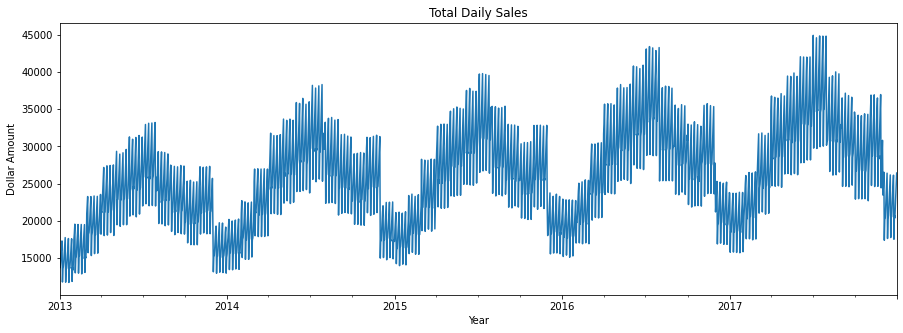

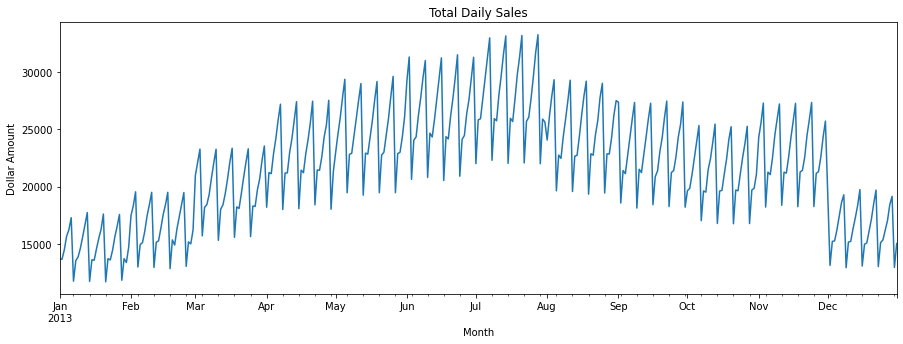

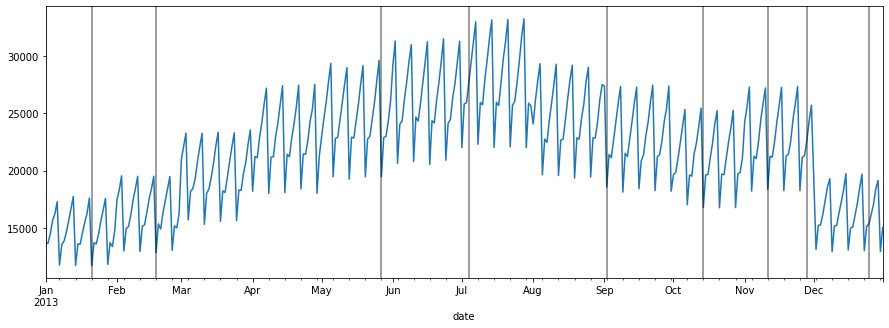

In [26]:
# The data exhibits:  yearly seasonality and some upward trend

# Also, by plotting the first year it becomes visible there is weekly seasonality

title='Total Daily Sales'
ylabel='Dollar Amount'
xlabel = "Year"

ax = df["sales"].plot(figsize=(15,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

plt.show()

title='Total Daily Sales'
ylabel='Dollar Amount'
xlabel = "Month"

ax = df["sales"][0:365].plot(figsize=(15,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

plt.show()


# Holidays are indentified by the black lines, difficult to see if holidays are impacting sales 

ax = df["sales"][0:365].plot(figsize =(15,5))

for day in df.query("Holiday ==1").index:
  ax.axvline(x=day, color = 'black', alpha = 0.5);

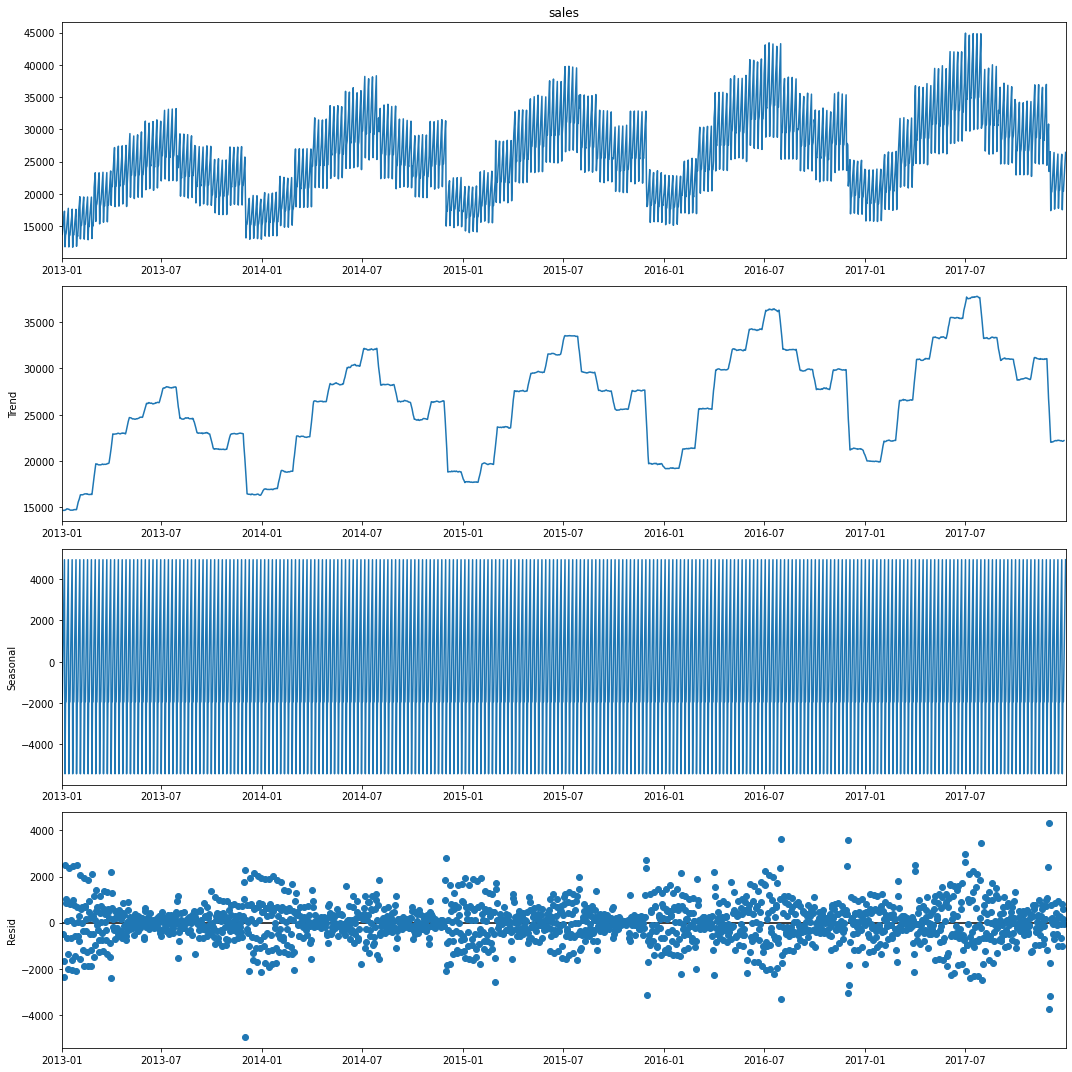

In [27]:
#Run an ETS to have a deeper look at the seasonality and trend in the data (additive becuase the trend does not appear exponential)

# Residuals look random - good indicator variance is constant over time

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

decomposition = seasonal_decompose(df["sales"], model='additive')
fig = decomposition.plot()
plt.show()



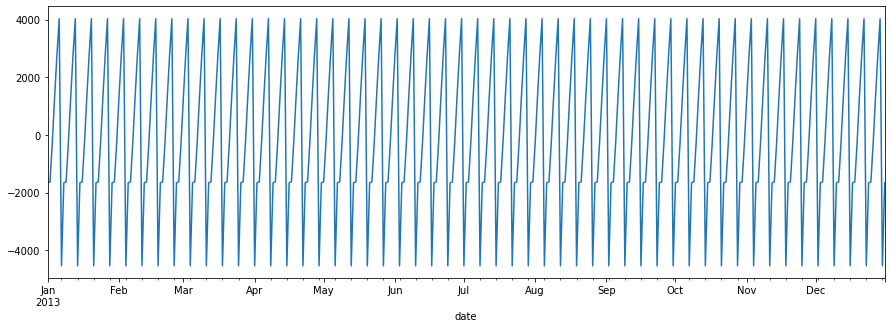

In [28]:
# Decomposing the data for one yearly cleary shows there is a weekly pattern

from pylab import rcParams
rcParams['figure.figsize']= 15, 5

decomposition = seasonal_decompose(df["sales"][0:365], model='additive')
fig = decomposition.seasonal.plot()
plt.show()

In [29]:
# Augmented Dickey-Fuller Test is a statistical test for wether or not the data has a trend (at some level of confidence) 

# Due to the the low p-value (<.05), the null-hypothesis of unit root (trend) is rejected

print('Augmented Dickey-Fuller Test')

dftest = adfuller(df['sales'],autolag='AIC')

dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test
ADF test statistic        -3.060244
p-value                    0.029639
# lags used               21.000000
# observations          1804.000000
critical value (1%)       -3.433980
critical value (5%)       -2.863143
critical value (10%)      -2.567624
dtype: float64


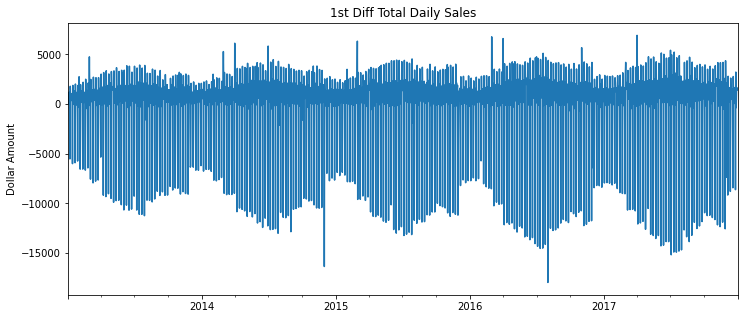

In [30]:
# Differencing is how to deal with a unit root (trend) in the data

#Since there is not unit root at only the .05 level, I think its best to difference the data (specially since it is an easy task)

first_dif = df["sales"].diff()[1:] #frist differencing the data

title='1st Diff Total Daily Sales'
ylabel='Dollar Amount'
xlabel='' # we don't really need a label here

ax = first_dif.plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

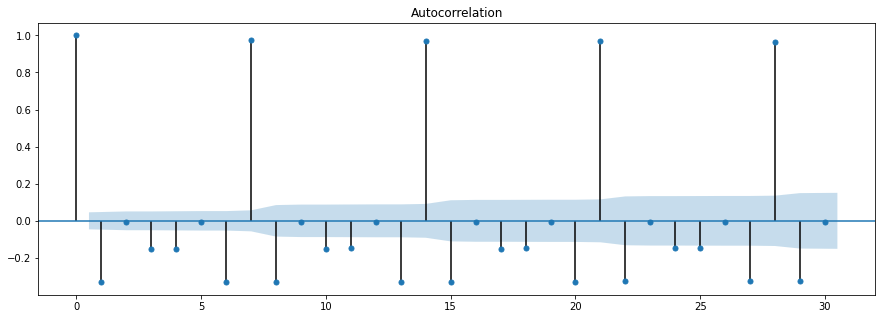

In [31]:
#Next, creating an ACF will identify the  number of lags for the seasonal MA part of the model
#Based on the chart it appears that seasonality is 7 days

# Outside blue shading is signficant 

plot_acf(first_dif, lags = 30)
plt.show()

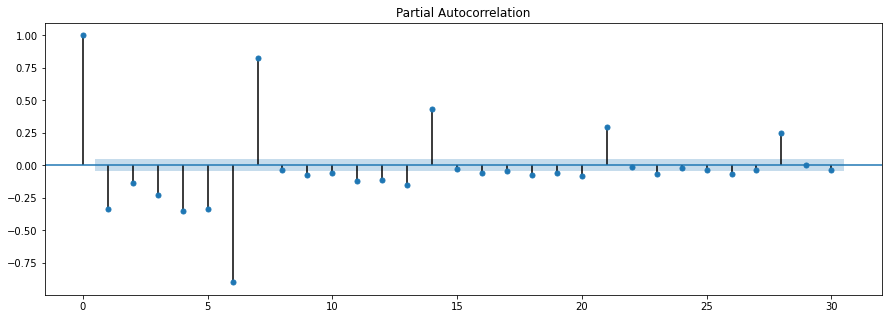

In [32]:
#The pacf chart shows the seasonal AR should contain 7 days



plot_pacf(first_dif, lags = 30)
plt.show()

In [33]:
# Initializing and finding the right parameters for the model

# SARIMA - due to the seasonality of the data we will use this model over an ARIMA (which is an extenstion of the ARIMA model but deals with seasonlity )
# The below auto_arima function essentially peforms a grid search for the beast model parameters


# print(auto_arima (df['sales'],seasonal=True,m=7).summary())

In [34]:

model = SARIMAX(df['sales'],order=(0,1,1),seasonal_order=(1,0,[1,2],7))
results = model.fit()
print(results.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                  sales   No. Observations:                 1826
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood              -14839.345
Date:                                Thu, 02 Sep 2021   AIC                          29688.690
Time:                                        18:28:02   BIC                          29716.237
Sample:                                    01-01-2013   HQIC                         29698.852
                                         - 12-31-2017                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1166      0.018     -6.523      0.000      -0.152      -0.082
ar.

In [35]:
train = df.iloc[:(1826-365)]
test = df.iloc[(1826-365):]

len(test)

365

In [36]:
# Predict Values

start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions').astype(int)

In [37]:
# Compare predictions to expected values


results_table=pd.concat([test, predictions,(test['sales']-predictions)], axis= 1).rename(columns={0:"Residuals_1"})

results_table

,sales,Holiday,SARIMA Predictions,Residuals_1
date,,,,
2017-01-01,23709,1,24981,-1272
2017-01-02,15772,1,15200,572
2017-01-03,18650,0,18560,90
2017-01-04,18510,0,18641,-131
2017-01-05,19895,0,19703,192
...,...,...,...,...
2017-12-27,20378,0,20846,-468
2017-12-28,21885,0,22090,-205
2017-12-29,23535,0,22564,971


In [38]:
results_table[results_table['Holiday'] == 1]


,sales,Holiday,SARIMA Predictions,Residuals_1
date,,,,
2017-01-01,23709,1,24981,-1272
2017-01-02,15772,1,15200,572
2017-01-16,15743,1,15526,217
2017-02-20,17435,1,18063,-628
2017-05-29,26194,1,26767,-573
2017-07-04,34737,1,34578,159
2017-09-04,24625,1,23233,1392
2017-10-09,22974,1,22447,527
2017-11-10,32846,1,32698,148


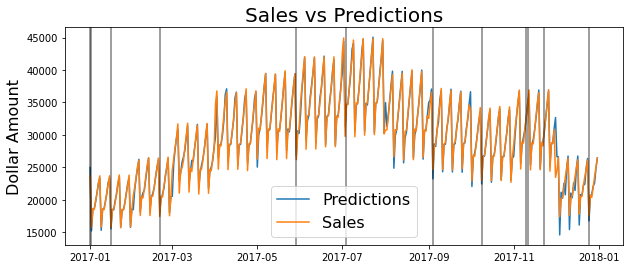

In [39]:
#Visually it looks like the model does a pretty good job at predicting sales 1 year in advance


plt.figure(figsize=(10,4))

plt.plot(results_table["SARIMA Predictions"])
plt.plot(df["sales"][(1826-365):])

plt.legend(('Predictions', 'Sales'), fontsize=16)

plt.title('Sales vs Predictions', fontsize=20)
plt.ylabel('Dollar Amount', fontsize=16)

for day in df[(1826-365):].query("Holiday ==1").index:
  plt.axvline(x=day, color = 'black', alpha = 0.5)

plt.show()




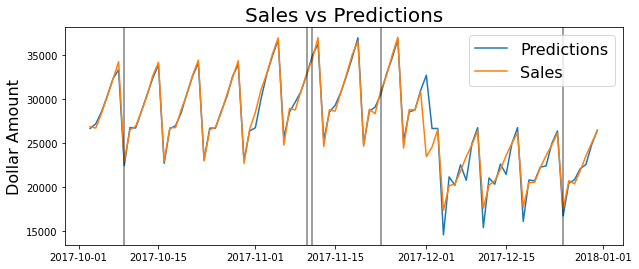

In [40]:
# It is hard to tell if holidays are having an effect with prediction error


plt.figure(figsize=(10,4))

plt.plot(results_table["SARIMA Predictions"][-90:])
plt.plot(df["sales"][(1826-90):])

plt.legend(('Predictions', 'Sales'), fontsize=16)

plt.title('Sales vs Predictions', fontsize=20)
plt.ylabel('Dollar Amount', fontsize=16)



for day in df[(1826-90):].query("Holiday ==1").index:
  plt.axvline(x=day, color = 'black', alpha = 0.5)

plt.show()

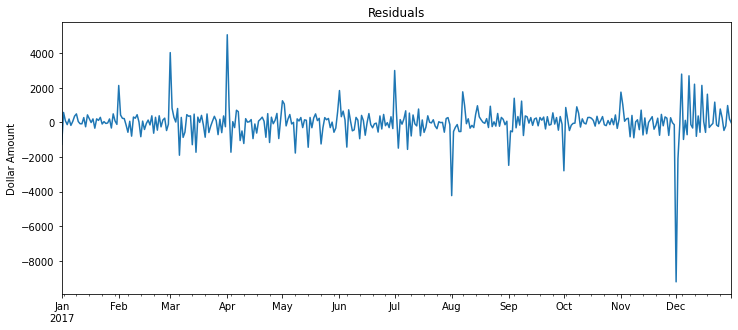

In [41]:
# The residuals look random

title='Residuals'
ylabel='Dollar Amount'


ax = results_table["Residuals_1"].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

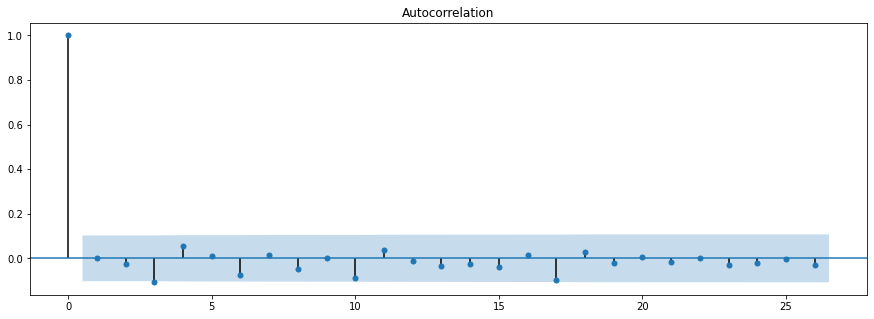

In [42]:
plot_acf(results_table["Residuals_1"])
plt.show()

In [43]:
#Evaluation metrics 

print('Mean Absolute Percent Error:', round(np.mean(abs(results_table["Residuals_1"]/results_table["sales"])),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(results_table["Residuals_1"]**2)))



Mean Absolute Percent Error: 0.0185
Root Mean Squared Error: 911.3674476617729


# Creating a SARIMAX model

Although it is hard to see if holidays are causing a higher maginatude in prediction error from the graph. 

Lets just create a SARIMAX model and compare with the SARIMA




In [44]:
model = SARIMAX(df['sales'],exongenous = df[['Holiday']],order=(0,1,1),seasonal_order=(1,0,[1,2],7))
results = model.fit()
print(results.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                  sales   No. Observations:                 1826
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood              -14839.345
Date:                                Thu, 02 Sep 2021   AIC                          29688.690
Time:                                        18:28:11   BIC                          29716.237
Sample:                                    01-01-2013   HQIC                         29698.852
                                         - 12-31-2017                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1166      0.018     -6.523      0.000      -0.152      -0.082
ar.

In [45]:
# Compare the RMSE between the two models

predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions').astype(int)
results_table['SARIMAX Pred.']=predictions
results_table["Residuals_2"] = results_table['sales'] - results_table['SARIMAX Pred.']

print('Root Mean Squared Error SARIMA:', np.sqrt(np.mean(results_table["Residuals_1"]**2)))
print('Root Mean Squared Error SARIMAX:', np.sqrt(np.mean(results_table["Residuals_2"]**2)))

Root Mean Squared Error SARIMA: 911.3674476617729
Root Mean Squared Error SARIMAX: 911.3674476617729


# Holidays have no affect on model predictions!

The RSME is identical between the two models